# Relationships using expression distance

This notebook is performing the same analysis as seen in [all_gene_relationships.ipynb](archive/all_gene_relationships.ipynb), where we are examining who is related to who. Previously we started with an accessory gene and asked: is the highest correlated gene another accessory gene or a core gene? For this analysis, we are starting with the most stable core genes and asking the same question: is the highest correlated gene core or accessory?

Note: We do not have the genome location metric here because this would require a significant effort to figure out how to modify the existing code to only focus on a subset of genes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from plotnine import (
    ggplot,
    labs,
    geom_hline,
    geom_bar,
    geom_errorbar,
    positions,
    aes,
    ggsave,
    theme_bw,
    theme,
    facet_wrap,
    scale_fill_manual,
    scale_x_continuous,
    xlim,
    guides,
    guide_legend,
    element_blank,
    element_text,
    element_rect,
    element_line,
    coords,
)

from scripts import utils, paths, gene_relationships, annotations

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
offset_to_bin = 10

use_operon = True
sum_increment_to_use = 1

# Output filename
pao1_figure_filename = (
    "PAO1_stablility_expression_relationships_operon_corrected_spell.svg"
)
pa14_figure_filename = (
    "PA14_stability_expression_relationships_operon_corrected_spell.svg"
)

### Import gene ids

In [3]:
# Import correlation matrix to get gene ids
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL

pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [4]:
# Make a dataframe with gene ids
pao1_membership = pd.DataFrame(data=[], index=pao1_corr.index)
print(pao1_membership.shape)
pao1_membership.head()

(5563, 0)


""
PA0001
PA0002
PA0003
PA0004
PA0005


In [5]:
pa14_membership = pd.DataFrame(data=[], index=pa14_corr.index)
print(pa14_membership.shape)
pa14_membership.head()

(5887, 0)


""
PA14_55610
PA14_55600
PA14_55590
PA14_55580
PA14_55570


### Import and format operon data

In [6]:
pao1_operon_filename = paths.PAO1_OPERON
pa14_operon_filename = paths.PA14_OPERON

In [7]:
pao1_operon = annotations.load_format_operons(pao1_operon_filename)
pa14_operon = annotations.load_format_operons(pa14_operon_filename)

In [8]:
print(pao1_operon.shape)
pao1_operon.head()

(3569, 1)


,operon_name
locus_tag,
PA0001,dnaA-dnaN-recF-gyrB
PA0002,dnaA-dnaN-recF-gyrB
PA0003,dnaA-dnaN-recF-gyrB
PA0004,dnaA-dnaN-recF-gyrB
PA0005,PA0006-lptA


In [9]:
if use_operon:
    pao1_operon_expression_to_use = pao1_operon
    pa14_operon_expression_to_use = pa14_operon
else:
    pao1_operon_expression_to_use = None
    pa14_operon_expression_to_use = None

### Map core/accessory labels to genes

In [10]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

In [11]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

In [12]:
(
    pao1_arr,
    pa14_arr,
    pao1_core,
    pao1_acc,
    pa14_core,
    pa14_acc,
) = annotations.map_core_acc_annot(
    pao1_membership,
    pa14_membership,
    pao1_expression_filename,
    pa14_expression_filename,
    pao1_annot_filename,
    pa14_annot_filename,
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [13]:
print(pao1_arr.shape)
pao1_arr.head()

(5563, 1)


,core/acc
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [14]:
pao1_arr.tail()

,core/acc
PA5566,core
PA5567,core
PA5568,core
PA5569,core
PA5570,acc


In [15]:
print(pa14_arr.shape)
pa14_arr.head()

(5887, 1)


,core/acc
PA14_00010,core
PA14_00020,core
PA14_00030,core
PA14_00050,core
PA14_00060,core


In [16]:
pa14_arr.tail()

,core/acc
PA14_73370,core
PA14_73390,core
PA14_73400,core
PA14_73410,core
PA14_73420,core


## Find relationships using expression distance

In [17]:
# Correlation matrix files
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL

In [18]:
# Load correlation data
pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [19]:
# Load transcriptional similarity df
# These are the subset of genes that we will consider
pao1_similarity_scores_filename = (
    "../3_core_core_analysis/pao1_core_similarity_associations_final_spell.tsv"
)
pa14_similarity_scores_filename = (
    "../3_core_core_analysis/pa14_core_similarity_associations_final_spell.tsv"
)

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)
pa14_similarity_scores = pd.read_csv(
    pa14_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [20]:
# Get most and least stable core genes
pao1_most_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "most stable"].index
)
pao1_least_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "least stable"].index
)

pa14_most_stable_genes = list(
    pa14_similarity_scores[pa14_similarity_scores["label"] == "most stable"].index
)
pa14_least_stable_genes = list(
    pa14_similarity_scores[pa14_similarity_scores["label"] == "least stable"].index
)

In [21]:
%%time
expression_dist_counts_pao1_most = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_most_stable_genes,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 3min 14s, sys: 20.3 ms, total: 3min 14s
Wall time: 3min 14s


In [22]:
%%time
expression_dist_counts_pao1_least = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_least_stable_genes,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 3min 14s, sys: 7.99 ms, total: 3min 14s
Wall time: 3min 14s


In [23]:
%%time
expression_dist_counts_pa14_most = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_most_stable_genes,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 3min 21s, sys: 40 ms, total: 3min 21s
Wall time: 3min 21s


In [24]:
%%time
expression_dist_counts_pa14_least = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_least_stable_genes,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 3min 27s, sys: 40 ms, total: 3min 27s
Wall time: 3min 27s


In [25]:
expression_dist_counts_pao1_most.head()

,offset,gene type,total
0,1,acc,1.0
1,2,acc,1.0
2,3,acc,1.0
3,4,acc,0.0
4,5,acc,1.0


In [26]:
expression_dist_counts_pao1_least.head()

,offset,gene type,total
0,1,acc,21.0
1,2,acc,19.0
2,3,acc,21.0
3,4,acc,25.0
4,5,acc,22.0


In [27]:
expression_dist_counts_pa14_most.head()

,offset,gene type,total
0,1,acc,1.0
1,2,acc,4.0
2,3,acc,4.0
3,4,acc,3.0
4,5,acc,6.0


In [28]:
expression_dist_counts_pa14_least.head()

,offset,gene type,total
0,1,acc,33.0
1,2,acc,44.0
2,3,acc,34.0
3,4,acc,33.0
4,5,acc,33.0


### Format data for plotting

Here we will calculate the proportion of gene types per offset and then normalize by the proportion of core and accessory genes. This will return an oddsratio type value where if the value is >1 than the proportion of genes of that type are more than expected.

In [29]:
# Calculate the percentages per offset
expression_dist_counts_pao1_most["percent"] = expression_dist_counts_pao1_most[
    "total"
] / len(pao1_most_stable_genes)
expression_dist_counts_pao1_least["percent"] = expression_dist_counts_pao1_least[
    "total"
] / len(pao1_least_stable_genes)

In [30]:
expression_dist_counts_pa14_most["percent"] = expression_dist_counts_pa14_most[
    "total"
] / len(pa14_most_stable_genes)
expression_dist_counts_pa14_least["percent"] = expression_dist_counts_pa14_least[
    "total"
] / len(pa14_least_stable_genes)

In [31]:
# Baseline/expected proportions for PAO1
pao1_total = len(pao1_core) + len(pao1_acc)
pao1_acc_expected = len(pao1_acc) / pao1_total
pao1_core_expected = len(pao1_core) / pao1_total
print("total pao1 genes", pao1_total)
print("pao1 acc baseline", pao1_acc_expected)
print("pao1 core baseline", pao1_core_expected)

total pao1 genes 5563
pao1 acc baseline 0.036311342800647135
pao1 core baseline 0.9636886571993528


In [32]:
# Baseline/expected proportions for PA14
pa14_total = len(pa14_core) + len(pa14_acc)
pa14_acc_expected = len(pa14_acc) / pa14_total
pa14_core_expected = len(pa14_core) / pa14_total
print("total pa14 genes", pa14_total)
print("pa14 acc baseline", pa14_acc_expected)
print("pa14 core baseline", pa14_core_expected)

total pa14 genes 5887
pa14 acc baseline 0.09002887718702225
pa14 core baseline 0.9099711228129778


In [33]:
# Normalize by baseline PAO1 most stable
pao1_acc_most_ids = expression_dist_counts_pao1_most.loc[
    expression_dist_counts_pao1_most["gene type"] == "acc"
].index
pao1_core_most_ids = expression_dist_counts_pao1_most.loc[
    expression_dist_counts_pao1_most["gene type"] == "core"
].index

expression_dist_counts_pao1_most.loc[pao1_acc_most_ids, "normalized"] = (
    expression_dist_counts_pao1_most.loc[pao1_acc_most_ids, "percent"]
    / pao1_acc_expected
)
expression_dist_counts_pao1_most.loc[pao1_core_most_ids, "normalized"] = (
    expression_dist_counts_pao1_most.loc[pao1_core_most_ids, "percent"]
    / pao1_core_expected
)

In [34]:
# Normalize by baseline PAO1 least stable
pao1_acc_least_ids = expression_dist_counts_pao1_least.loc[
    expression_dist_counts_pao1_least["gene type"] == "acc"
].index
pao1_core_least_ids = expression_dist_counts_pao1_least.loc[
    expression_dist_counts_pao1_least["gene type"] == "core"
].index

expression_dist_counts_pao1_least.loc[pao1_acc_least_ids, "normalized"] = (
    expression_dist_counts_pao1_least.loc[pao1_acc_least_ids, "percent"]
    / pao1_acc_expected
)
expression_dist_counts_pao1_least.loc[pao1_core_least_ids, "normalized"] = (
    expression_dist_counts_pao1_least.loc[pao1_core_least_ids, "percent"]
    / pao1_core_expected
)

In [35]:
# Normalize by baseline PA14 most stable
pa14_acc_most_ids = expression_dist_counts_pa14_most.loc[
    expression_dist_counts_pa14_most["gene type"] == "acc"
].index
pa14_core_most_ids = expression_dist_counts_pao1_most.loc[
    expression_dist_counts_pa14_most["gene type"] == "core"
].index

expression_dist_counts_pa14_most.loc[pa14_acc_most_ids, "normalized"] = (
    expression_dist_counts_pa14_most.loc[pa14_acc_most_ids, "percent"]
    / pa14_acc_expected
)
expression_dist_counts_pa14_most.loc[pa14_core_most_ids, "normalized"] = (
    expression_dist_counts_pa14_most.loc[pa14_core_most_ids, "percent"]
    / pa14_core_expected
)

In [36]:
# Normalize by baseline PA14 least stable
pa14_acc_least_ids = expression_dist_counts_pa14_least.loc[
    expression_dist_counts_pa14_least["gene type"] == "acc"
].index
pa14_core_least_ids = expression_dist_counts_pa14_least.loc[
    expression_dist_counts_pa14_least["gene type"] == "core"
].index

expression_dist_counts_pa14_least.loc[pa14_acc_least_ids, "normalized"] = (
    expression_dist_counts_pa14_least.loc[pa14_acc_least_ids, "percent"]
    / pa14_acc_expected
)
expression_dist_counts_pa14_least.loc[pa14_core_least_ids, "normalized"] = (
    expression_dist_counts_pa14_least.loc[pa14_core_least_ids, "percent"]
    / pa14_core_expected
)

In [37]:
# Combine PAO1 dataframes
expression_dist_counts_pao1_most.loc[pao1_acc_most_ids, "label"] = "most stable acc"
expression_dist_counts_pao1_most.loc[pao1_core_most_ids, "label"] = "most stable core"
expression_dist_counts_pao1_least.loc[pao1_acc_least_ids, "label"] = "least stable acc"
expression_dist_counts_pao1_least.loc[
    pao1_core_least_ids, "label"
] = "least stable core"

In [38]:
# Combine PA14 dataframes
expression_dist_counts_pa14_most.loc[pa14_acc_most_ids, "label"] = "most stable acc"
expression_dist_counts_pa14_most.loc[pa14_core_most_ids, "label"] = "most stable core"
expression_dist_counts_pa14_least.loc[pa14_acc_least_ids, "label"] = "least stable acc"
expression_dist_counts_pa14_least.loc[
    pa14_core_least_ids, "label"
] = "least stable core"

### Add confidence interval

In [39]:
# Import confidence interval data
pao1_most_ci = pd.read_csv("pao1_most_ci.tsv", sep="\t", index_col=0, header=0)
pao1_least_ci = pd.read_csv("pao1_least_ci.tsv", sep="\t", index_col=0, header=0)

pa14_most_ci = pd.read_csv("pa14_most_ci.tsv", sep="\t", index_col=0, header=0)
pa14_least_ci = pd.read_csv("pa14_least_ci.tsv", sep="\t", index_col=0, header=0)

In [40]:
expression_dist_counts_pao1_most = expression_dist_counts_pao1_most.merge(
    pao1_most_ci[["ymin", "ymax"]], left_index=True, right_index=True
)
expression_dist_counts_pao1_least = expression_dist_counts_pao1_least.merge(
    pao1_least_ci[["ymin", "ymax"]], left_index=True, right_index=True
)

In [41]:
expression_dist_counts_pa14_most = expression_dist_counts_pa14_most.merge(
    pa14_most_ci[["ymin", "ymax"]], left_index=True, right_index=True
)
expression_dist_counts_pa14_least = expression_dist_counts_pa14_least.merge(
    pa14_least_ci[["ymin", "ymax"]], left_index=True, right_index=True
)

In [42]:
expression_dist_counts_pao1_all = pd.concat(
    [expression_dist_counts_pao1_most, expression_dist_counts_pao1_least]
)

In [43]:
expression_dist_counts_pao1_all

,offset,gene type,total,percent,normalized,label,ymin,ymax
0,1,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.389371
1,2,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.286226
2,3,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.309434
3,4,acc,0.000000,0.000000,0.000000,most stable acc,0.000000,0.000000
4,5,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.412578
5,6,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.309434
6,7,acc,0.000000,0.000000,0.000000,most stable acc,0.000000,0.000000
7,8,acc,1.000000,0.003745,0.103145,most stable acc,0.000000,0.286226
8,9,acc,2.000000,0.007491,0.206289,most stable acc,0.000000,0.595660
9,10,acc,2.000000,0.007491,0.206289,most stable acc,0.000000,0.515723


In [44]:
expression_dist_counts_pa14_all = pd.concat(
    [expression_dist_counts_pa14_most, expression_dist_counts_pa14_least]
)

In [45]:
expression_dist_counts_pa14_all

,offset,gene type,total,percent,normalized,label,ymin,ymax
0,1,acc,1.000000,0.003745,0.041601,most stable acc,0.000000,0.115444
1,2,acc,4.000000,0.014981,0.166405,most stable acc,0.041601,0.281849
2,3,acc,4.000000,0.014981,0.166405,most stable acc,0.041601,0.323450
3,4,acc,3.000000,0.011236,0.124804,most stable acc,0.000000,0.249608
4,5,acc,6.000000,0.022472,0.249608,most stable acc,0.092563,0.471135
5,6,acc,1.000000,0.003745,0.041601,most stable acc,0.000000,0.115444
6,7,acc,5.000000,0.018727,0.208007,most stable acc,0.083203,0.406653
7,8,acc,1.000000,0.003745,0.041601,most stable acc,0.000000,0.124804
8,9,acc,7.000000,0.026217,0.291209,most stable acc,0.092563,0.489855
9,10,acc,1.000000,0.003745,0.041601,most stable acc,0.000000,0.124804


### Plot

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


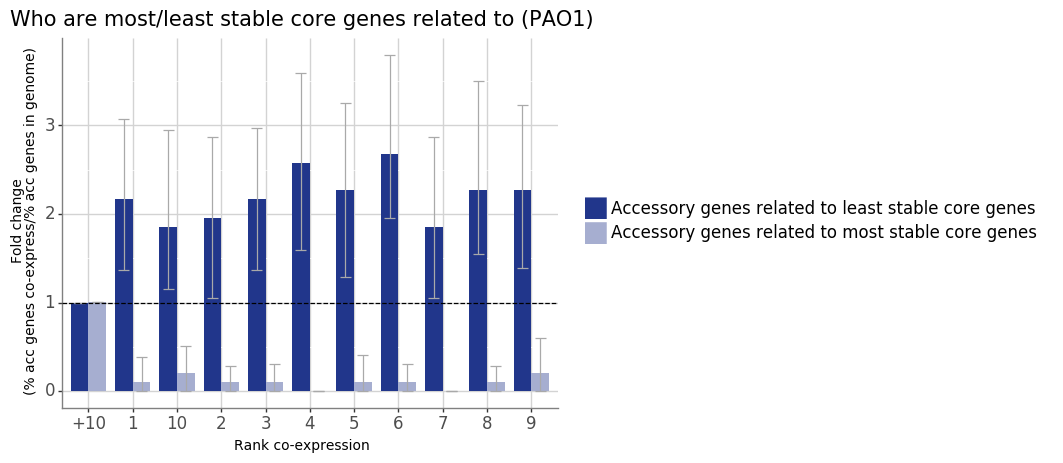

<ggplot: (8747628264305)>


In [46]:
pao1_subset = expression_dist_counts_pao1_all[
    (expression_dist_counts_pao1_all["gene type"] == "acc")
]
pao1_subset["offset"] = list(pao1_subset["offset"].astype("str"))
# x_ticks = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "10+",
#          "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "10+"]

fig_pao1 = (
    ggplot(pao1_subset, aes(x="offset", y="normalized", fill="label"))
    + geom_bar(stat="identity", position="dodge", width=0.8)
    + geom_errorbar(
        pao1_subset,
        aes(x="offset", ymin="ymin", ymax="ymax"),
        position=positions.position_dodge(0.8),
        color="darkgrey",
    )
    + geom_hline(aes(yintercept=1.0), linetype="dashed")
    + labs(
        x="Rank co-expression",
        y=r"Fold change" + "\n" + "(% acc genes co-express/% acc genes in genome)",
        title="Who are most/least stable core genes related to (PAO1)",
    )
    + theme(
        plot_background=element_rect(fill="white"),
        panel_background=element_rect(fill="white"),
        panel_grid_major_x=element_line(color="lightgrey"),
        panel_grid_major_y=element_line(color="lightgrey"),
        axis_line=element_line(color="grey"),
        legend_key=element_rect(fill="white", colour="white"),
        legend_title=element_blank(),
        legend_text=element_text(family="sans-serif", size=12),
        plot_title=element_text(family="sans-serif", size=15),
        axis_text=element_text(family="sans-serif", size=12),
        axis_title=element_text(family="sans-serif", size=10),
    )
    # + scale_x_discrete(breaks=x_ticks, labels=x_ticks) \
    + scale_fill_manual(
        values=["#21368B", "#A6AED0"],
        labels=[
            "Accessory genes related to least stable core genes",
            "Accessory genes related to most stable core genes",
        ],
    )
)
print(fig_pao1)

# TO DO: Need to figure out how to fix the ordering of the x-tick labels

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


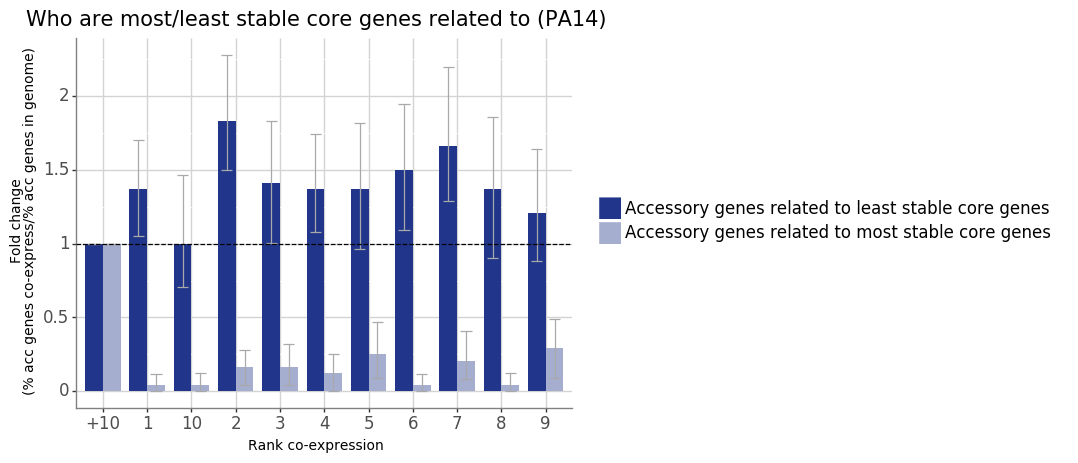

<ggplot: (8747628264185)>


In [47]:
pa14_subset = expression_dist_counts_pa14_all[
    (expression_dist_counts_pa14_all["gene type"] == "acc")
]
pa14_subset["offset"] = list(pa14_subset["offset"].astype("str"))

fig_pa14 = (
    ggplot(pa14_subset, aes(x="offset", y="normalized", fill="label"))
    + geom_bar(stat="identity", position="dodge", width=0.8)
    + geom_errorbar(
        pa14_subset,
        aes(x="offset", ymin="ymin", ymax="ymax"),
        position=positions.position_dodge(0.8),
        color="darkgrey",
    )
    + geom_hline(aes(yintercept=1.0), linetype="dashed")
    + labs(
        x="Rank co-expression",
        y=r"Fold change" + "\n" + "(% acc genes co-express/% acc genes in genome)",
        title="Who are most/least stable core genes related to (PA14)",
    )
    + theme(
        plot_background=element_rect(fill="white"),
        panel_background=element_rect(fill="white"),
        panel_grid_major_x=element_line(color="lightgrey"),
        panel_grid_major_y=element_line(color="lightgrey"),
        axis_line=element_line(color="grey"),
        legend_key=element_rect(fill="white", colour="white"),
        legend_title=element_blank(),
        legend_text=element_text(family="sans-serif", size=12),
        plot_title=element_text(family="sans-serif", size=15),
        axis_text=element_text(family="sans-serif", size=12),
        axis_title=element_text(family="sans-serif", size=10),
    )
    + scale_fill_manual(
        values=["#21368B", "#A6AED0"],
        labels=[
            "Accessory genes related to least stable core genes",
            "Accessory genes related to most stable core genes",
        ],
    )
)
print(fig_pa14)

In [48]:
# Calculate statistical test between the distribution of the top 10 co-expressed
# genes related to the least stable vs the most stable core genes
# Test: mean number of co-expressed accessory genes in least stable group vs mean number of
# co-expressed accessory genes in most stable group
# (compare dark blue and light blue bars)

pao1_least_df = pao1_subset[pao1_subset["label"] == "least stable acc"]
pao1_least_df = pao1_least_df[pao1_least_df.offset != "+10"]
pao1_least_vals = pao1_least_df["normalized"].values

pao1_most_df = pao1_subset[pao1_subset["label"] == "most stable acc"]
pao1_most_df = pao1_most_df[pao1_most_df.offset != "+10"]
pao1_most_vals = pao1_most_df["normalized"].values

# Independent t-test
# Test the null hypothesis such that the means of two populations are equal
(pao1_stats, pao1_pvalue) = scipy.stats.ttest_ind(pao1_least_vals, pao1_most_vals)
print(pao1_stats, pao1_pvalue)

# Non-parametric test
# nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations,
# the probability of X being greater than Y is equal to the probability of Y being greater than X.
(pao1_stats, pao1_pvalue) = scipy.stats.mannwhitneyu(pao1_least_vals, pao1_most_vals)
print(pao1_stats, pao1_pvalue)

23.400404854797294 6.303772008432746e-15
0.0 7.123389909274272e-05


In [49]:
pa14_least_df = pa14_subset[pa14_subset["label"] == "least stable acc"]
pa14_least_df = pa14_least_df[pa14_least_df.offset != "+10"]
pa14_least_vals = pa14_least_df["normalized"].values

pa14_most_df = pa14_subset[pa14_subset["label"] == "most stable acc"]
pa14_most_df = pa14_most_df[pa14_most_df.offset != "+10"]
pa14_most_vals = pa14_most_df["normalized"].values

# Independent t-test
(pa14_stats, pa14_pvalue) = scipy.stats.ttest_ind(pa14_least_vals, pa14_most_vals)
print(pa14_stats, pa14_pvalue)

# Non-parametric test
(pa14_stats, pa14_pvalue) = scipy.stats.mannwhitneyu(pa14_least_vals, pa14_most_vals)
print(pa14_stats, pa14_pvalue)

16.356388005040372 3.0028363518414738e-12
0.0 8.105536723700735e-05


Based on the bar plots we can be confident in our trend (as seen by the confidence intervals) that least stable genes are more co-expressed with accessory genes compared to most stable genes. This difference between least and most stable genes is further quantified by the t-test comparing the distribution of accessory genes related least vs most genes.

In [50]:
"""# Plot PAO1 trends
plt.figure(figsize=(10, 8))

pao1_subset = expression_dist_counts_pao1_all[
    (expression_dist_counts_pao1_all["gene type"] == "acc")
]

fig = sns.barplot(
    data=pao1_subset,
    x="offset",
    y="normalized",
    hue="label",
    hue_order=[
        "most stable acc",
        "least stable acc",
        # "most stable core",
        # "least stable core",
    ],
    palette={
        "most stable acc": "#21368B",
        "least stable acc": "#A6AED0",
        # "most stable core": "#F8744C",
        # "least stable core": "#FCC7B7",
    },
    estimator=np.mean,
    ci=90,
    n_boot=5,
    errcolor="red",
    errwidth=2,
)
plt.errorbar(
    x=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "10+"],
    y=pao1_subset["normalized"],
    yerr=(
        (pao1_subset["ymax"] - pao1_subset["ymin"]
        )
    ),
)

plt.axhline(y=1.0, color="black", linestyle="--")
fig.set_title("Who are most/least stable core genes related to (PAO1)", fontsize=16)
fig.set_ylabel(
    r"Fold change" + "\n" + "(% acc genes co-express/% acc genes in genome)",
    fontsize=14,
)
fig.set_xlabel("Rank correlation in expression space", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.0, fontsize=12)

# new_labels = ["Most stable gene", "Least stable gene"]
# for t, l in zip(fig._legend.texts, new_labels): t.set_text(l)"""

'# Plot PAO1 trends\nplt.figure(figsize=(10, 8))\n\npao1_subset = expression_dist_counts_pao1_all[\n    (expression_dist_counts_pao1_all["gene type"] == "acc")\n]\n\nfig = sns.barplot(\n    data=pao1_subset,\n    x="offset",\n    y="normalized",\n    hue="label",\n    hue_order=[\n        "most stable acc",\n        "least stable acc",\n        # "most stable core",\n        # "least stable core",\n    ],\n    palette={\n        "most stable acc": "#21368B",\n        "least stable acc": "#A6AED0",\n        # "most stable core": "#F8744C",\n        # "least stable core": "#FCC7B7",\n    },\n    estimator=np.mean,\n    ci=90,\n    n_boot=5,\n    errcolor="red",\n    errwidth=2,\n)\nplt.errorbar(\n    x=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "10+"],\n    y=pao1_subset["normalized"],\n    yerr=(\n        (pao1_subset["ymax"] - pao1_subset["ymin"]\n        )\n    ),\n)\n\nplt.axhline(y=1.0, color="black", linestyle="--")\nfig.set_title("Who are most/least stable core genes rela

In [51]:
"""# Plot PA14 trends
plt.figure(figsize=(10, 8))

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_all[
        expression_dist_counts_pa14_all["gene type"] == "acc"
    ],
    x="offset",
    y="normalized",
    hue="label",
    hue_order=[
        "most stable acc",
        "least stable acc",
        # "most stable core",
        # "least stable core",
    ],
    palette={
        "most stable acc": "#21368B",
        "least stable acc": "#A6AED0",
        # "most stable core": "#F8744C",
        # "least stable core": "#FCC7B7",
    },
)
plt.axhline(y=1.0, color="black", linestyle="--")
fig2.set_title("Who are most/least stable core genes related to (PA14)", fontsize=16)
fig2.set_ylabel(
    r"Fold change" + "\n" + "(% acc genes co-express/% acc genes in genome)",
    fontsize=14,
)
fig2.set_xlabel("Rank correlation in expression space", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.0, fontsize=12)"""

'# Plot PA14 trends\nplt.figure(figsize=(10, 8))\n\nfig2 = sns.barplot(\n    data=expression_dist_counts_pa14_all[\n        expression_dist_counts_pa14_all["gene type"] == "acc"\n    ],\n    x="offset",\n    y="normalized",\n    hue="label",\n    hue_order=[\n        "most stable acc",\n        "least stable acc",\n        # "most stable core",\n        # "least stable core",\n    ],\n    palette={\n        "most stable acc": "#21368B",\n        "least stable acc": "#A6AED0",\n        # "most stable core": "#F8744C",\n        # "least stable core": "#FCC7B7",\n    },\n)\nplt.axhline(y=1.0, color="black", linestyle="--")\nfig2.set_title("Who are most/least stable core genes related to (PA14)", fontsize=16)\nfig2.set_ylabel(\n    r"Fold change" + "\n" + "(% acc genes co-express/% acc genes in genome)",\n    fontsize=14,\n)\nfig2.set_xlabel("Rank correlation in expression space", fontsize=14)\nplt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.0, fontsize=12)'

In [52]:
ggsave(plot=fig_pao1, filename=pao1_figure_filename, device="svg", dpi=300)
ggsave(plot=fig_pa14, filename=pa14_figure_filename, device="svg", dpi=300)

"""# Save figures using operons
# Save figures not using operons
# Save figure with rolling sum and operons
# Save figure with rolling sum not using operons
fig.figure.savefig(
    pao1_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

fig2.figure.savefig(
    pa14_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)"""

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: PAO1_stablility_expression_relationships_operon_corrected_spell.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:70

'# Save figures using operons\n# Save figures not using operons\n# Save figure with rolling sum and operons\n# Save figure with rolling sum not using operons\nfig.figure.savefig(\n    pao1_figure_filename,\n    format="svg",\n    bbox_inches="tight",\n    transparent=True,\n    pad_inches=0,\n    dpi=300,\n)\n\nfig2.figure.savefig(\n    pa14_figure_filename,\n    format="svg",\n    bbox_inches="tight",\n    transparent=True,\n    pad_inches=0,\n    dpi=300,\n)'

**Takeaway:**

* Least stable core genes have more accessory gene neighbors compared to most stable core genes
* Previous evidence found that insertion sequences (type of accessory gene) can change the expression of existing genes once it is integrated into the genome. So perhaps these least stable core genes transcriptional behavior is modified by the accessory genes.